## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2024.

## **Task 2: RNN Application - Time Series Forecasting** (25%)

# Forecasting Task

The purpose of this workbook is to teach you how to use neural networks to do time series forecasting. Time series is a collection of discrete data points indexed over time. Being able to predict what the next data point will be in a squence is a valuable toolset which has implications for climate science, finance, healthscience, economics, earthquake prediction, and many more fields.

For our assignment, we are going to be examing data from Microsoft Stock's value over a 7 year period. This task is going to focus on data processing & splitting, model selection, training and forecasting on time series data.

## Import Packages
First we need to install Pandas. Pandas is a very popular data science package for Python. It is especially great at creating DataFrames to store discrete data. You can read more about Pandas at: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html


In [1]:
# Run this cell to install Pandas
!pip install -q pandas

In [2]:
# Import modules
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data

In [4]:
# Load the data from the CSV and display the Pandas DataFrame Head (first 5 rows of the DataFrame)
df = pd.read_csv('stock_data/Microsoft_Stock.csv')
df['Date'] = pd.to_datetime(df['Date'])
open_prices = df['Open'].values
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


Now, lets plot the data to visualize what the open price looks like over time.
For this assignment we are only going to focus on the open price.

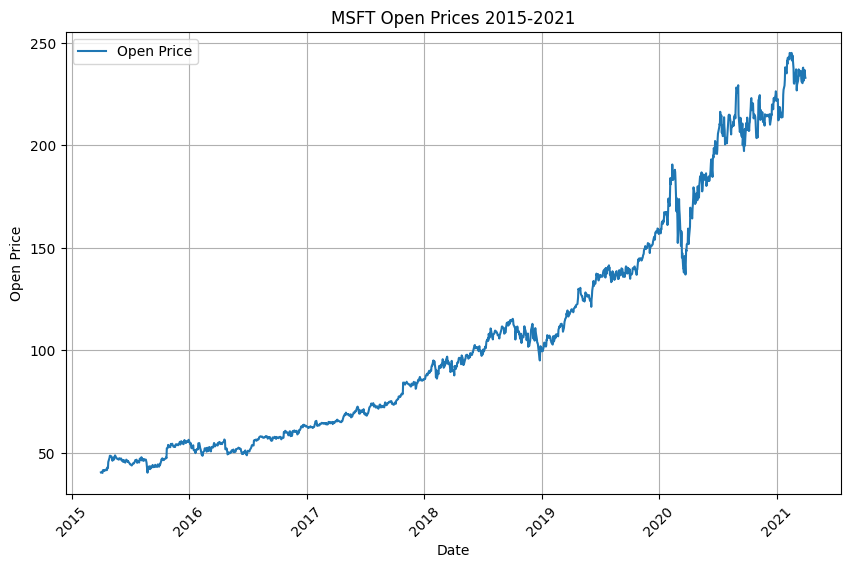

In [5]:
# Plot 'Open' vs 'Date'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df['Date'], open_prices, label='Open Price')

# Add labels and Title
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('MSFT Open Prices 2015-2021')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.legend()
plt.show()

## Create Lookback Dataset (5%)
To ensure the dataset has the right "lookback window" for making predictions, we need to feed the model a sequence of past data points leading up to the target point. For example, if we want to predict the value at time $t=6$, we should use data points from $t=0$ to $t=5$ as the input $X$ for the model. The target value, $y$, for this input sequence would then be the data point at $t=6$. Importantly, the lookback window (in this case, 6 data points) should always exclude the actual point we’re trying to predict. This ensures that the model is only using historical data to make its predictions, rather than information from the future.

To implement this, we’ll create a function that generates a lookback dataset by passing a sliding window over the data. The length of this window, or "lookback," determines how many data points are included in each sequence. Here, we’ll set the lookback to a default of 10, though this can be adjusted later when fine-tuning the model. For now, start with a lookback of 10 as a baseline.

Before generating the lookback dataset, we also need to normalize the data (`open_prices`) to standardize the range of input values. To do this, perform a standard normalization by subtracting the mean of `open_prices` from each data point and then dividing by the standard deviation. This normalized data is then ready to be passed to the lookback function, which will create the dataset for training the model.

<center>
<img src="https://github.com/ecbme4040/e4040-2024fall-assign3-by2360/blob/main/img/lookback.png?raw=1" width="500" class="center"/>
</center>

<font color="red"><strong>TODO:</strong></font> Normalize the data following the description above.

In [6]:
###################################################
# TODO: Set open_prices_normalized following the  #
#       description above.                        #
#                                                 #
###################################################

open_prices_normalized = (open_prices - np.mean(open_prices)) / np.std(open_prices)

###################################################
# ENDTODO #
###################################################

<font color="red"><strong>TODO:</strong></font> Complete the `create_dataset` function following the description above.

In [7]:
def create_dataset(data, lookback = 10):
    X, y = [], []
    ###################################################
    # TODO: Create the lookback dataset following the #
    #       description above.                        #
    #                                                 #
    ###################################################

    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])

    ###################################################
    # ENDTODO #
    ###################################################

    return np.array(X), np.array(y)

# Define the lookback period (You can change this later)
lookback = 10

# Prepare the dataset with lookback
X, y = create_dataset(open_prices_normalized, lookback)


# If this was done correctly, the number of samples for X and y should be equal,
# X should also have the lookback number as the second dimension.
print("X_open_prices_lookback", X.shape)
print("y_open_prices", y.shape)

X_open_prices_lookback (1501, 10)
y_open_prices (1501,)


## Split Data into Training, Validation, and Test (5%)

By this point in your data science career, you have become familiar with good practice in splitting data
between training, validation, and testing. To properly set up the dataset for time series forecasting, we’ll split the data again into training, validation, and testing sets. However unlike other types of data we have worked with thus far in the class, time series data requires that we maintain the order of observations, so we can't use random selection to split the data. Instead, we’ll divide it sequentially: the first 70% of the data will be used for training, the next 15% for validation, and the final 15% for testing.

You will first have to calculate the number of entries for each group: training, validation, and testing. Then you can split the `X` data, `y` data, and the timestamps in similar fashions.

<font color="red"><strong>TODO:</strong></font> Split the dataset into training, validation, and testing following the description above.

In [12]:
###################################################
# TODO: Split the dataset and fill in the empty   #
#       variables following the description above #
#                                                 #
###################################################

size = X.shape[0]

# Calculate the index sizes for the splits
train_size = int(size * 0.7)
val_size = int(size * 0.15)
test_size = size - train_size - val_size

# Split the data into train, validation, and test sets
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Split timestamps into train, validation, and test
lookback_timestamps = df['Date'][lookback:];

train_timestamps = lookback_timestamps[:train_size]
val_timestamps = lookback_timestamps[train_size:train_size + val_size]
test_timestamps = lookback_timestamps[train_size + val_size:]


###################################################
# ENDTODO #
###################################################



# Reshape X_train, X_val, and X_test from 2D (samples, lookback) to 3D shape (samples, lookback, features=1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Print the sizes of each dataset to confirm
print("Train", X_train.shape, y_train.shape, train_timestamps.shape);
print("Validation", X_val.shape, y_val.shape, val_timestamps.shape);
print("Test", X_test.shape, y_test.shape, test_timestamps.shape);

Train (1050, 10, 1) (1050,) (1050,)
Validation (225, 10, 1) (225,) (225,)
Test (226, 10, 1) (226,) (226,)


## Visualize the split dataset

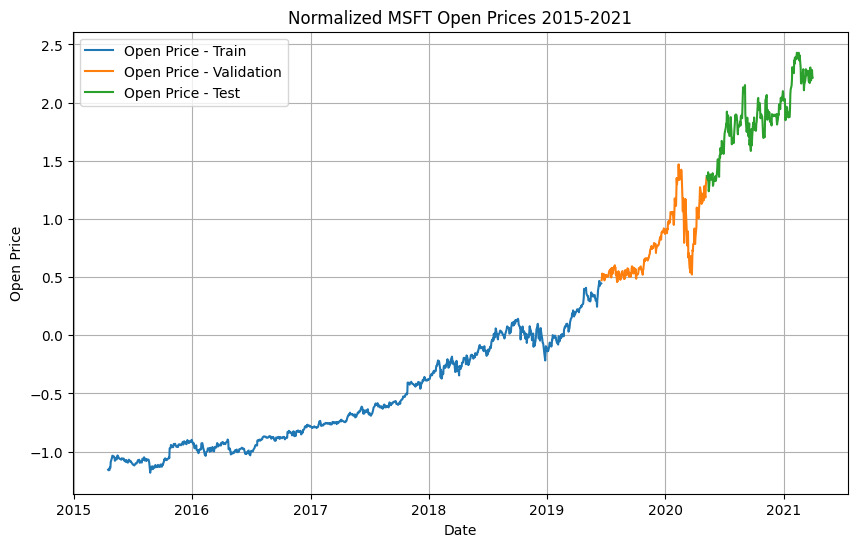

In [13]:
# Plot the Normalized Data Splits
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(train_timestamps, y_train, label='Open Price - Train')
plt.plot(val_timestamps, y_val, label='Open Price - Validation')
plt.plot(test_timestamps, y_test, label='Open Price - Test')


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Normalized MSFT Open Prices 2015-2021')
plt.grid(True)
plt.legend()
plt.show()

<span style="color:red">__TODO:__</span> Why do you think we split the data sequentially instead of randomly? Answer in 1-3 sentences.

<span style="color:red">__Answer:__ The data contains trend that's encoded in time, which would be lost if the data is splitted in random. </span>

## Building the Neural Network (5%)
For this part of the task, you’ll create a neural network model using TensorFlow’s Sequential API. The goal is to design a model for time series forecasting by experimenting with various layer types, layer counts, and unit configurations.

Begin by constructing a basic Sequential model with an InputLayer that matches the shape of your lookback data (the number of time steps and feature dimension). Start with at least one recurrent layer, like LSTM, GRU, or a simple RNN, and follow it with a Dense layer to produce the final output. Experiment with different combinations and configurations, such as adding additional Dense layers or stacking multiple RNN/LSTM/GRU layers with different numbers of units. Once the model structure is defined, consider applying optional techniques we learned in class: dropout, batch normalization, early stopping to monitor validation performance, etc.

Remember, the purpose of this neural network is to take in a lookback window and produce a prediction for a single point, `y_predict`, which is then compared to the actual label, `y`. This is a regression problem, and you need to think about the output layer when designing your model.

<center>
<img src="https://github.com/ecbme4040/e4040-2024fall-assign3-by2360/blob/main/img/prediction.png?raw=1" width="500" class="center"/>
</center>

<span style="color:red">__TODO:__</span> Build an RNN-based model for time series forecasting using TensorFlow and Keras following the instructions above.

In [78]:
###################################################
# TODO: Declare your TensorFlow model             #
#                                                 #
###################################################

# Declare your TF Keras model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

out_data = y_train.reshape((y_train.shape[0], 1))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

ts_model = Sequential()
ts_model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
ts_model.add(LSTM(32, return_sequences=True))
ts_model.add(TimeDistributed(Dense(16, activation='relu')))
ts_model.add(TimeDistributed(Dense(out_data.shape[-1], activation='linear')))

ts_model.summary()

###################################################
# ENDTODO #
###################################################

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 10, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 10, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 10, 16)              │             528 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 10, 1)               │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,217 (51.63 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

<span style="color:red">__TODO:__</span> Briefly describe the decisions you made regarding the design of your neural network and why you made those decisions. Please answer in a few short sentences.

<span style="color:red">__Answer:__</span>

## Compile and Train your model (6%)

Compile your model by setting an optimizer, a learning rate, and an appropriate loss function for this regression problem. Experiment with different learning rates to find the one that best suits your model’s performance, and select a suitable optimizer and loss function. Remember, this is a regression task and think about how that would affect your loss function.

<span style="color:red">__TODO:__</span> Choose a learning rate, an optimizer, and a loss function, then compile your model.

In [79]:
###################################################
# TODO: Select hyperparameters for compiling your #
#       model                                     #
#                                                 #
###################################################

# Select hyperparameters
LEARNING_RATE = 0.001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS = 'mse'


###################################################
# ENDTODO #
###################################################


ts_model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS
)

Select the number of epochs and the batch size, include additional items like early stopping call backs if you desire and then train your model. Remember to use your validation data! To read more about the `fit()` function which you will need to train your Tensorflow Keras model, check out the TF guide: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

We want to get the training history from the fit function so that we can graph the training progress. This will provide insights into your model’s learning progress and any potential overfitting or underfitting.

<span style="color:red">__TODO:__</span> Choose training parameters and train your model following the description above.

In [80]:
###################################################
# TODO: Select parameters for your training       #
#       and train your model following the        #
#       instructions above.                       #
#                                                 #
###################################################

# Hyperparameters
EPOCHS = 35
BATCH_SIZE = 64

# Train your model
out_val_data = y_val.reshape((y_val.shape[0], 1))

history = ts_model.fit(
    X_train,
    out_data,
    validation_data=(X_val, out_val_data),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

###################################################
# ENDTODO #
###################################################

Epoch 1/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.4549 - val_loss: 0.5793
Epoch 2/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1851 - val_loss: 0.5337
Epoch 3/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1205 - val_loss: 0.4516
Epoch 4/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0807 - val_loss: 0.3301
Epoch 5/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0577 - val_loss: 0.2787
Epoch 6/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0494 - val_loss: 0.2803
Epoch 7/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0397 - val_loss: 0.2668
Epoch 8/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0339 - val_loss: 0.2434
Epoch 9/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280 - val_loss: 0.2237
Epoch 10/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0237 - val_loss: 0.2123
Epoch 11/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0201 - val_loss: 0.1972
Epoch 12/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179 - val_l

<span style="color:red">__TODO:__</span> Run the following cell to plot your loss.

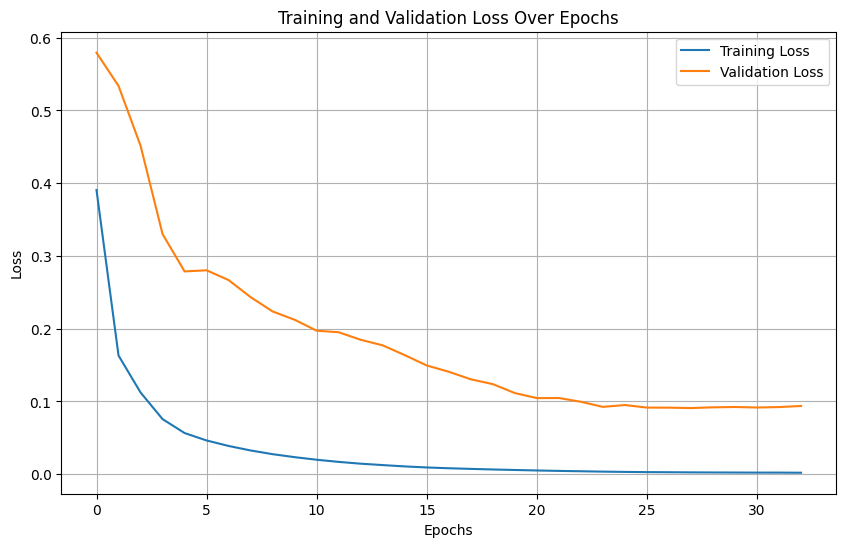

In [81]:
# Extract the loss values for training and validation
train_loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add labels and title
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

<span style="color:red">__TODO:__</span> Does your training graph indicate signs of overfitting? Answer in 1-2 sentences.

<span style="color:red">__Answer:__ No, both training and validation loss seems to flatten, which suggests that the model reaches its capacity to learn from the data. </span>

## Evalute the Model's Performance (4%)
Use your model to make predictions for the training, validation, and test data sets.
Now remember the data is all normalized so the output of this model will also be normalized.
We will provided the code to graph your normalized predictions against the normalized labels.
However, if you really wanted to calculate Microsofts stocks remember de-normalize your data!

<span style="color:red">__TODO:__</span> Use the TF Keras `predict()` function to get the output. https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict. Then see how well the model performed on the test dataset.

In [82]:
###################################################
# TODO: Generate predictions for each of the      #
#       dataset splits                            #
#                                                 #
###################################################

# Generate predictions for training, validation, and test data
y_train_pred_norm = ts_model.predict(X_train)
y_val_pred_norm = ts_model.predict(X_val)
y_test_pred_norm = ts_model.predict(X_test)

y_train_pred_norm = y_train_pred_norm.squeeze()[:, -1]
y_val_pred_norm = y_val_pred_norm.squeeze()[:, -1]
y_test_pred_norm = y_test_pred_norm.squeeze()[:, -1]

###################################################
# ENDTODO #
###################################################

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Training Loss: 0.0012702991
Validation Loss: 0.028417813
Test Loss: 1.0377816


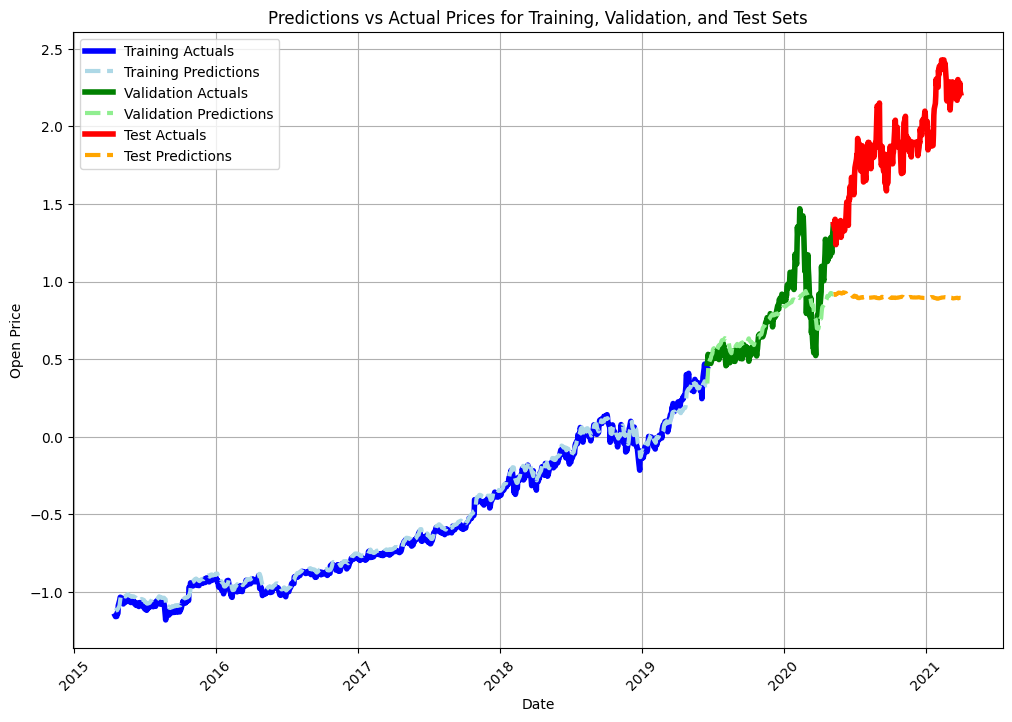

In [83]:
# Create MSE loss function
mse_loss = tf.keras.losses.MeanSquaredError()

# Calculate mean squared error for each dataset
train_loss = mse_loss(y_train, y_train_pred_norm).numpy()
val_loss = mse_loss(y_val, y_val_pred_norm).numpy()
test_loss = mse_loss(y_test, y_test_pred_norm).numpy()

print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)
print("Test Loss:", test_loss)


# Plotting the predictions and actual values
plt.figure(figsize=(12, 8))

# Plot for training data
plt.plot(train_timestamps, y_train, label='Training Actuals',
         color='blue', linewidth = 4)
plt.plot(train_timestamps, y_train_pred_norm, label='Training Predictions',
         color='lightblue', linestyle='--', linewidth = 3)

# Plot for validation data
plt.plot(val_timestamps, y_val, label='Validation Actuals',
         color='green', linewidth = 4)
plt.plot(val_timestamps, y_val_pred_norm, label='Validation Predictions',
         color='lightgreen', linestyle='--', linewidth = 3)

# Plot for test data
plt.plot(test_timestamps, y_test, label='Test Actuals',
         color='red', linewidth = 4)
plt.plot(test_timestamps, y_test_pred_norm, label='Test Predictions',
         color='orange', linestyle='--', linewidth = 3)

# Add labels, legend, and grid
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Predictions vs Actual Prices for Training, Validation, and Test Sets')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

<span style="color:red">__TODO:__</span> How well did your model perform on the validation and test data? Answer in 2-3 sentences.

<span style="color:red">__Answer:__ It performed ok on the first part of the validation set, but when the price increase and fluctuation increases, it failed to predict the rest of the prices. </span>